# RoC Analysis Random Forest

## Data Generation
* Fix a beta* value and number of predictors
* Create a Y vector using Bernoulli distribution for logit
* Create a X vector using normal distribution as i.i.ds

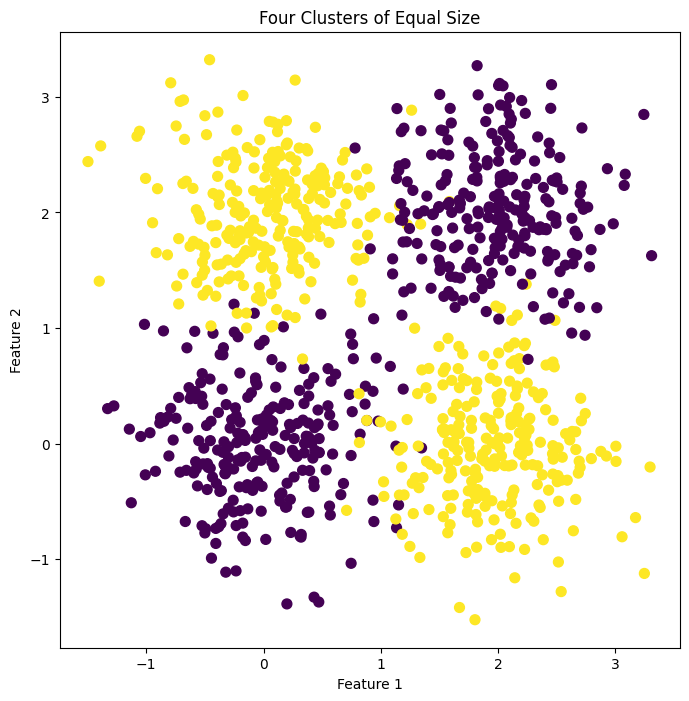

Training data shape: (800, 2), (800,)
Test data shape: (200, 2), (200,)


In [1]:
no_predictors = 2
no_samples = 1000
no_classes = 2
#kerneltype = 'linear'  #comment out for polynomial kernel
#kerneltype = 'poly'  #comment out for linear kernel

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

n_samples_per_cluster = 250
n_clusters = 4

# Create the clusters deterministically
np.random.seed(0) # for reproducibility

X = np.zeros((n_samples_per_cluster * n_clusters, 2))
y = np.zeros(n_samples_per_cluster * n_clusters)

# Cluster centers in corners of a square
centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

# Assign points to clusters deterministically
for i in range(n_clusters):
    cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
    X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
    if i == 0 or i == 3:
        y[cluster_indices] = 0
    else:
        y[cluster_indices] = 1



#Visualize
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
plt.title('Four Clusters of Equal Size')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#add intercept to X
#X = np.hstack((np.ones((X.shape[0], 1)), X))

# # shuffle data
# permutation = np.random.permutation(no_samples)
# X = X[permutation]
# y = y[permutation]


#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")





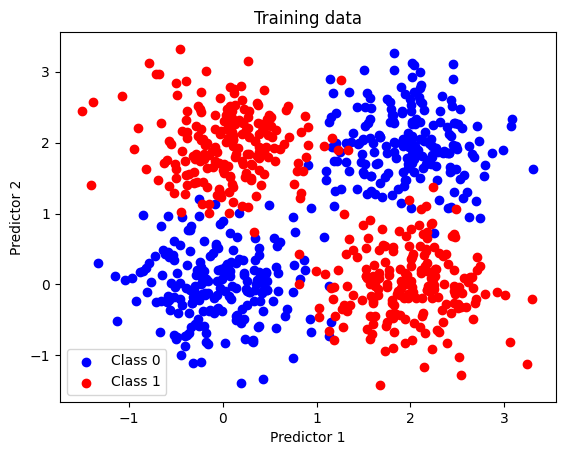

In [2]:
plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='b', label='Class 0') 
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Training data')
plt.show()

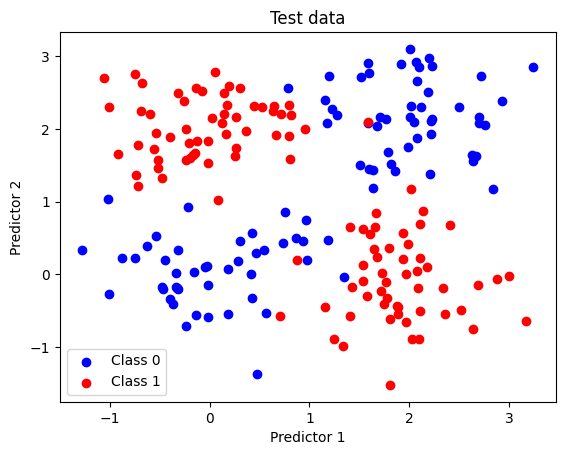

In [3]:
plt.figure()
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Test data')
plt.show()

## Random Forest based classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

## Standard RoC curve

Length of threshold prc 44
Length of threshold_roc 27


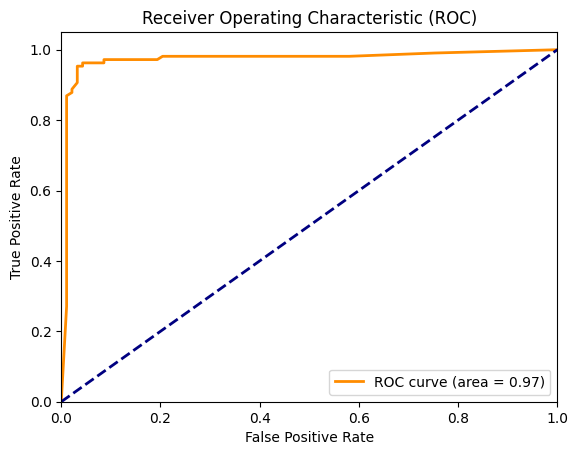

In [5]:
# Plot the RoC curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
precision_prc, recall_prc, threshold_prc = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

print("Length of threshold prc", len(threshold_prc))
print("Length of threshold_roc", len(threshold_roc))

roc_auc = auc(fpr_roc, tpr_roc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## RoC curve by cost-sensitive learning

The following function fixes the threshold value. The input model to the function will be weighted in order to have the bias towards the minority class

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_pred = clf_model.predict(X_test) # predict directly

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





Class1_final 407000, w 0.001
Class1_final 404184, w 0.0010069669156754365
Class1_final 401387, w 0.0010139823692649028
Class1_final 398610, w 0.0010210466989279507
Class1_final 395852, w 0.0010281602451800657
Class1_final 393113, w 0.0010353233509090714
Class1_final 390394, w 0.0010425363613916652
Class1_final 387693, w 0.0010497996243100584
Class1_final 385010, w 0.0010571134897687316
Class1_final 382346, w 0.0010644783103113168
Class1_final 379701, w 0.001071894440937588
Class1_final 377074, w 0.0010793622391205694
Class1_final 374465, w 0.001086882064823774
Class1_final 371874, w 0.0010944542805185456
Class1_final 369301, w 0.001102079251201539
Class1_final 366746, w 0.0011097573444123093
Class1_final 364209, w 0.0011174889302510262
Class1_final 361689, w 0.001125274381396319
Class1_final 359187, w 0.0011331140731232372
Class1_final 356702, w 0.0011410083833213373
Class1_final 354234, w 0.0011489576925129044
Class1_final 351783, w 0.001156962383871286
Class1_final 349349, w 0.001165

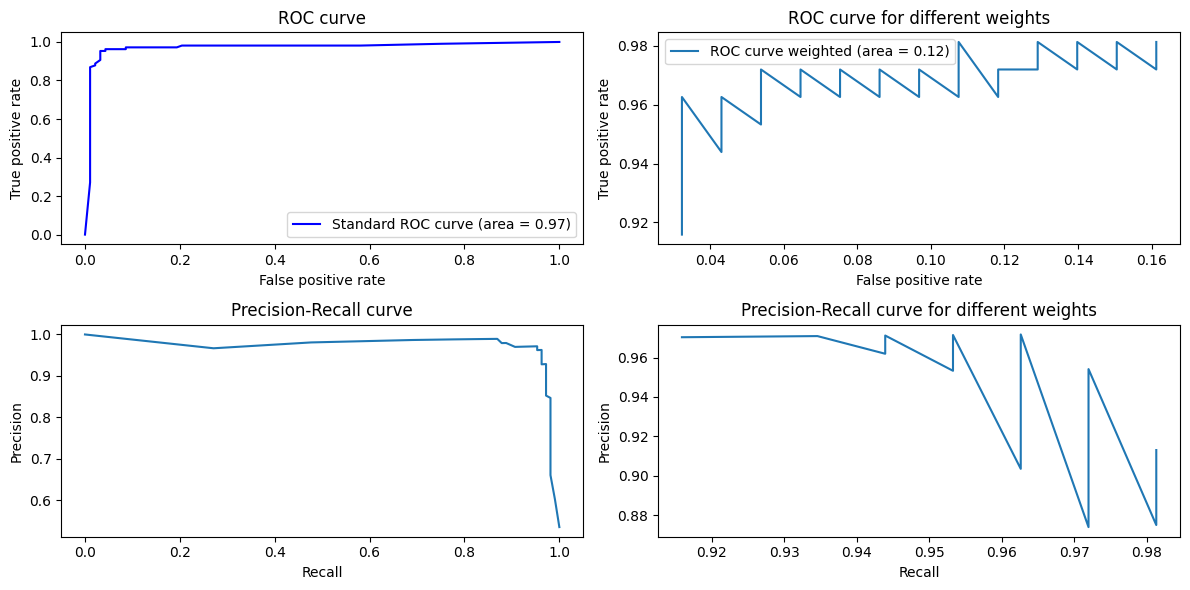

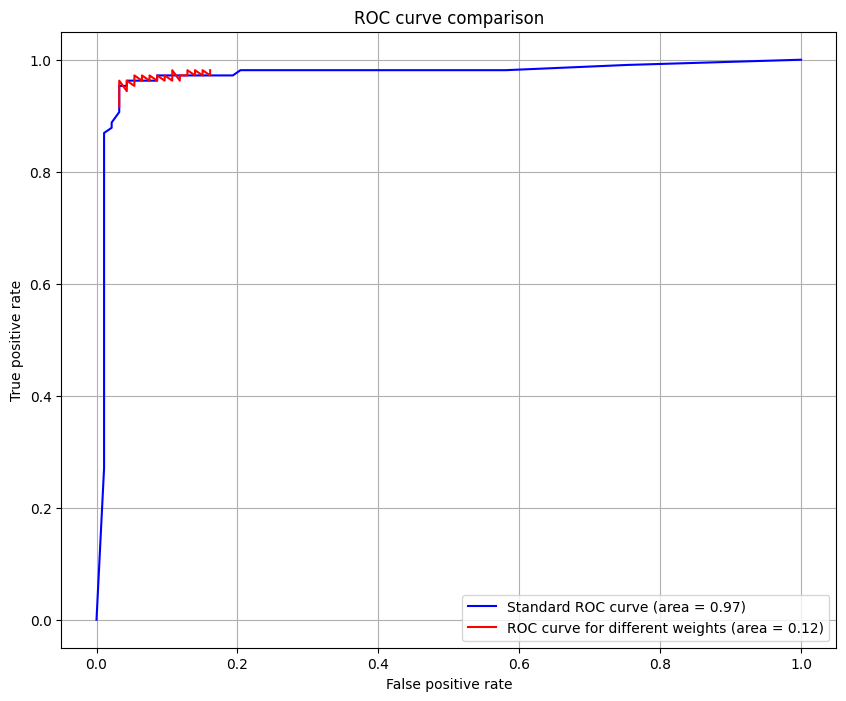

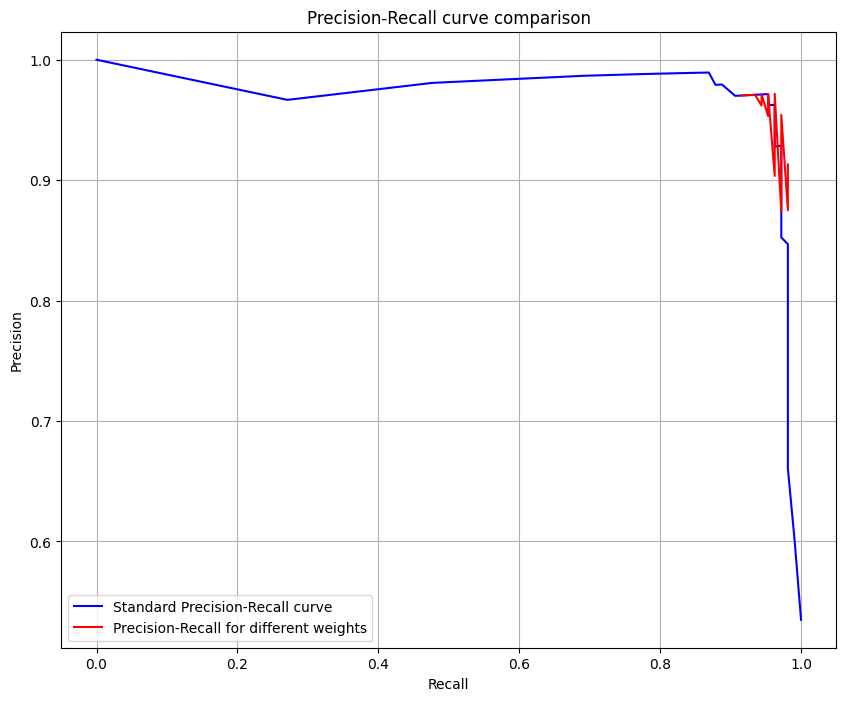

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# count the class 0 and class 1 samples in y_train
counter = Counter(y_train)
Class0_initial = counter[0]
Class1_initial = counter[1]

# Weight the X_train and y_train for cost-sensitive learning
class_ratio = Class0_initial / Class1_initial
#alpha_target = np.arange(class_ratio-0.99, class_ratio+0.99, 0.01)

# Define the number of points below and above the class_ratio
# You can adjust these to control the density of points
num_points_below = 50
num_points_above = 50
class_ratio_low = 0.001  # Minimum value for class_ratio
class_ratio_high = 1000.0  # Maximum value for class_ratio

# Generate points below class_ratio with smaller increments
# Using geomspace for a geometric progression
if class_ratio > class_ratio_low:
    alpha_below = np.geomspace(class_ratio_low, class_ratio, num_points_below, endpoint=False)
else:
    alpha_below = np.array([]) # Handle cases where class_ratio is very small

# Generate points above class_ratio with larger, geometric increments
if class_ratio < class_ratio_high:
    alpha_above = np.geomspace(class_ratio, class_ratio_high, num_points_above)
else:
    # If class_ratio is already >= 1000, we might just want 1000 or an empty array
    alpha_above = np.array([class_ratio_high]) if class_ratio == class_ratio_high else (np.array([]) if class_ratio > class_ratio_high else np.geomspace(class_ratio, class_ratio_high, num_points_above))


# Combine the arrays and remove duplicates (especially class_ratio itself)
alpha_target = np.unique(np.concatenate((alpha_below, alpha_above)))

dict_weighted_clfs = {}
for w in alpha_target:
    
    # calculate the class weights
    if w >= class_ratio:
        Class0_final = int(Class1_initial * w)
        print(f"Class0_final {Class0_final}, w {w}")
        if Class0_final < Class0_initial:
            print(f"Class0_final {Class0_final} is less than Class0_initial {Class0_initial}")
        sampling_strategy_dict = {0: Class0_final}
    elif w < class_ratio:
        Class1_final = int(Class0_initial / w)
        print(f"Class1_final {Class1_final}, w {w}")
        if Class1_final < Class1_initial:
            print(f"Class1_final {Class1_final} is less than Class1_initial {Class1_initial}")
        sampling_strategy_dict = {1: Class1_final}

    smote = SMOTE(sampling_strategy=sampling_strategy_dict, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


## Updated resampling

Class1_final 407000, w 0.001
  INFO: Applying localized scaling: Clustering 406607 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 204731 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 201876 samples for localized std dev adjustment.
  INFO: Localized scaling applied.
Class1_final 354234, w 0.0011489576925129044
  INFO: Applying localized scaling: Clustering 353841 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 178335 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 175506 samples for localized std dev adjustment.
  INFO: Localized scaling applied.
Class1_final 308309, w 0.0013201037791845764
  INFO: Applying localized scaling: Clustering 307916 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 155163 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Me

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Class0_final 468, w 1.1915605236635434
  INFO: Applying localized scaling: Clustering 61 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 25 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 36 samples for localized std dev adjustment.
  INFO: Localized scaling applied.
Class0_final 538, w 1.3709775853819701
  INFO: Applying localized scaling: Clustering 131 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 58 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 73 samples for localized std dev adjustment.
  INFO: Localized scaling applied.
Class0_final 619, w 1.5774100453083715
  INFO: Applying localized scaling: Clustering 212 synthetic samples into 2 groups.
    INFO: Processing synthetic K-Means cluster 0 with 100 samples for localized std dev adjustment.
    INFO: Processing synthetic K-Means cluster 1 with 112 samples 

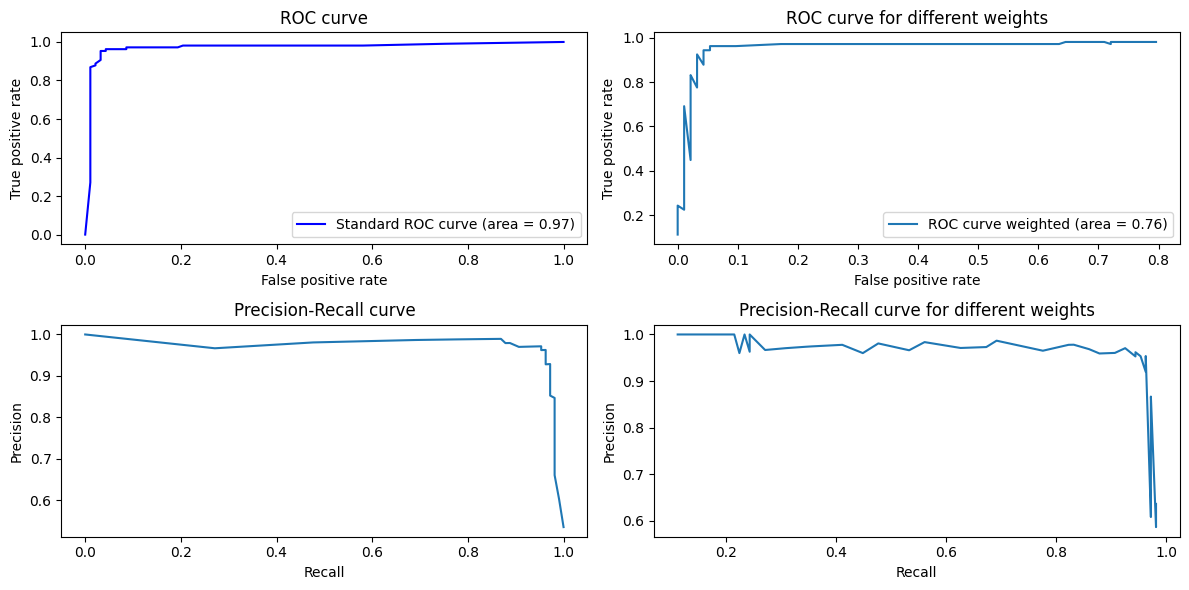

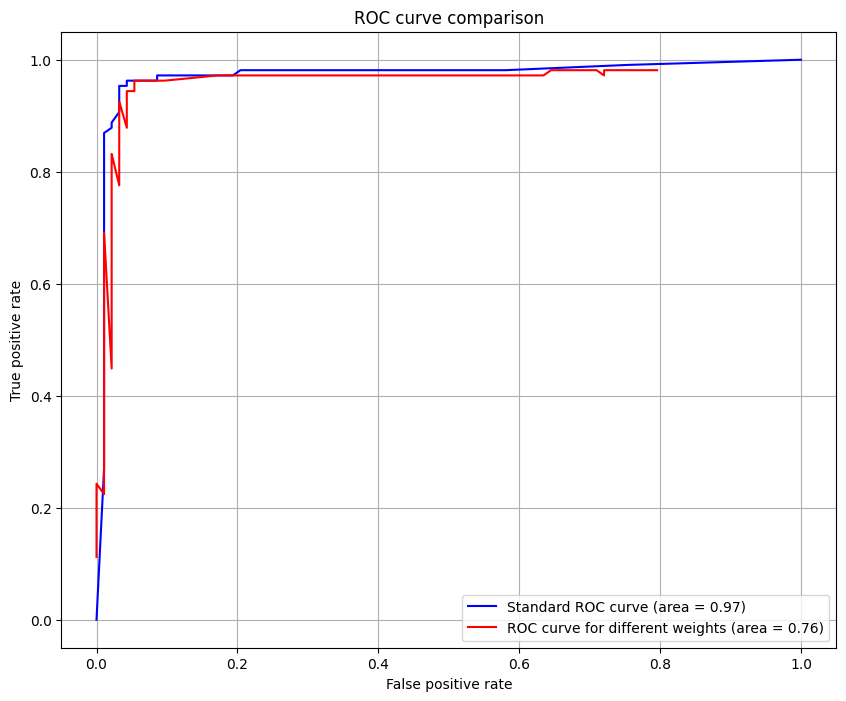

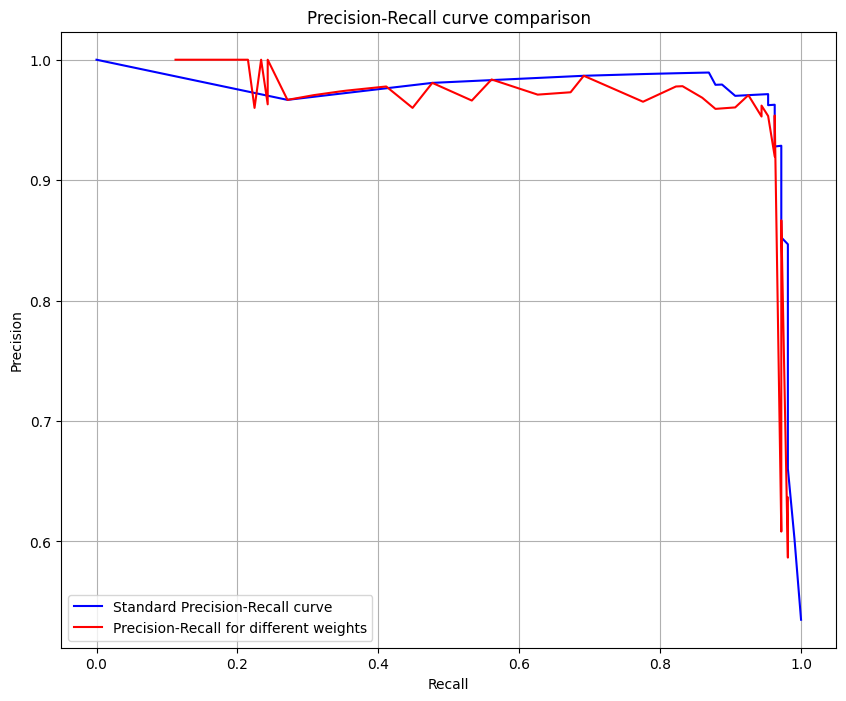

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.cluster import KMeans

# count the class 0 and class 1 samples in y_train
counter = Counter(y_train)
Class0_initial = counter[0]
Class1_initial = counter[1]

# Weight the X_train and y_train for cost-sensitive learning
class_ratio = Class0_initial / Class1_initial
#alpha_target = np.arange(class_ratio-0.99, class_ratio+0.99, 0.01)

# Define the number of points below and above the class_ratio
# You can adjust these to control the density of points
num_points_below = 50
num_points_above = 50
class_ratio_low = 0.001  # Minimum value for class_ratio
class_ratio_high = 1000.0  # Maximum value for class_ratio

# --- Configuration ---
STD_MIN_VALUE = 0.5
STD_MAX_VALUE = 2.0
EPSILON = 1e-9  # For checking non-zero std dev

log_class_ratio_low = np.log(class_ratio_low)
log_class_ratio_high = np.log(class_ratio_high)

# Define expected modes for each class (you'll need to set this based on your data)
# Example: {class_label: number_of_modes}
EXPECTED_MODES_PER_CLASS = {
    0: 2,  # Assuming class 0 has 2 modes
    1: 2   # Assuming class 1 has 2 modes
}

# Generate points below class_ratio with smaller increments
# Using geomspace for a geometric progression
if class_ratio > class_ratio_low:
    alpha_below = np.geomspace(class_ratio_low, class_ratio, num_points_below, endpoint=False)
else:
    alpha_below = np.array([]) # Handle cases where class_ratio is very small

# Generate points above class_ratio with larger, geometric increments
if class_ratio < class_ratio_high:
    alpha_above = np.geomspace(class_ratio, class_ratio_high, num_points_above)
else:
    # If class_ratio is already >= 1000, we might just want 1000 or an empty array
    alpha_above = np.array([class_ratio_high]) if class_ratio == class_ratio_high else (np.array([]) if class_ratio > class_ratio_high else np.geomspace(class_ratio, class_ratio_high, num_points_above))


# Combine the arrays and remove duplicates (especially class_ratio itself)
alpha_target = np.unique(np.concatenate((alpha_below, alpha_above)))

dict_weighted_clfs = {}
for w in alpha_target:
    
    # calculate the class weights
    if w >= class_ratio:
        Class0_final = int(Class1_initial * w)
        print(f"Class0_final {Class0_final}, w {w}")
        if Class0_final < Class0_initial:
            print(f"Class0_final {Class0_final} is less than Class0_initial {Class0_initial}")
        sampling_strategy_dict = {0: Class0_final}
    elif w < class_ratio:
        Class1_final = int(Class0_initial / w)
        print(f"Class1_final {Class1_final}, w {w}")
        if Class1_final < Class1_initial:
            print(f"Class1_final {Class1_final} is less than Class1_initial {Class1_initial}")
        sampling_strategy_dict = {1: Class1_final}

    smote = SMOTE(sampling_strategy=sampling_strategy_dict, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    X_modified_resampled = X_resampled.copy()
    start_idx_synthetic = len(y_train) 
    num_synthetic_generated = len(y_resampled) - len(y_train)
    synthetic_samples_original_features = X_resampled[start_idx_synthetic:]
    n_clusters_for_synthetic = 2
    MIN_SAMPLES_PER_SYNTHETIC_CLUSTER = 5
    MIN_SAMPLES_FOR_CLUSTERING_GLOBAL = 10

    # Scale the standard deviation of the synthetic samples
    log_w = np.log(w)
    proportion = (log_w - log_class_ratio_low) / (log_class_ratio_high - log_class_ratio_low)
    proportion = np.clip(proportion, 0.0, 1.0)  # Ensure it's within [0, 1]
    target_std_for_synthetic = STD_MIN_VALUE + proportion * (STD_MAX_VALUE - STD_MIN_VALUE)

    # Attempt localized scaling if enough samples and modes > 1
    attempt_localized_scaling = (n_clusters_for_synthetic > 1 and
                                    num_synthetic_generated >= n_clusters_for_synthetic * MIN_SAMPLES_PER_SYNTHETIC_CLUSTER and
                                    num_synthetic_generated >= MIN_SAMPLES_FOR_CLUSTERING_GLOBAL)

    if attempt_localized_scaling:
        print(f"  INFO: Applying localized scaling: Clustering {num_synthetic_generated} synthetic samples into {n_clusters_for_synthetic} groups.")
        try:
            kmeans = KMeans(n_clusters=n_clusters_for_synthetic, random_state=42, n_init='auto')
            cluster_labels_for_synthetic = kmeans.fit_predict(synthetic_samples_original_features)

            for i in range(n_clusters_for_synthetic):
                current_cluster_indices_in_block = np.where(cluster_labels_for_synthetic == i)[0]
                
                if len(current_cluster_indices_in_block) < MIN_SAMPLES_PER_SYNTHETIC_CLUSTER:
                    print(f"    WARNING: Synthetic cluster {i} has only {len(current_cluster_indices_in_block)} samples. Applying global scaling to this small cluster's points (within block).")
                    # Fallback for this specific small cluster: scale it globally (within its own points) Localized scaling is not possible
                    # Scale the small cluster's points globally
                    # This is a fallback to ensure we don't skip small clusters
                    if len(current_cluster_indices_in_block) > 0:
                        small_cluster_global_indices = start_idx_synthetic + current_cluster_indices_in_block
                        for feature_idx in range(X_modified_resampled.shape[1]):
                            feature_data_small_cluster = X_modified_resampled[small_cluster_global_indices, feature_idx]
                            mean_val = np.mean(feature_data_small_cluster)
                            std_val = np.std(feature_data_small_cluster)
                            if std_val > EPSILON:
                                centered = feature_data_small_cluster - mean_val
                                scaled = centered * (target_std_for_synthetic / std_val)
                                X_modified_resampled[small_cluster_global_indices, feature_idx] = scaled + mean_val
                    continue # Move to next K-Means cluster
                
                print(f"    INFO: Processing synthetic K-Means cluster {i} with {len(current_cluster_indices_in_block)} samples for localized std dev adjustment.")
                current_cluster_global_indices = start_idx_synthetic + current_cluster_indices_in_block

                for feature_idx in range(X_modified_resampled.shape[1]):
                    feature_data_current_cluster = X_modified_resampled[current_cluster_global_indices, feature_idx]
                    mean_feature_current_cluster = np.mean(feature_data_current_cluster)
                    std_feature_current_cluster = np.std(feature_data_current_cluster)

                    if std_feature_current_cluster > EPSILON:
                        centered_data = feature_data_current_cluster - mean_feature_current_cluster
                        scaled_data = centered_data * (target_std_for_synthetic / std_feature_current_cluster)
                        X_modified_resampled[current_cluster_global_indices, feature_idx] = scaled_data + mean_feature_current_cluster
                    else:
                        print(f"    WARNING: Feature {feature_idx} in synthetic cluster {i} has std dev ~0. Not scaling.")
            print("  INFO: Localized scaling applied.")
        except Exception as e:
            print(f"  ERROR: Error during K-Means clustering or localized scaling: {e}. Applying global scaling as fallback for all synthetic samples.")
            attempt_localized_scaling = False # Force global fallback
    
    if not attempt_localized_scaling: # Global scaling for all synthetic points
        if n_clusters_for_synthetic > 1 : # Only print if localized was intended but failed/skipped
                print(f"  INFO: Applying global scaling for all {num_synthetic_generated} synthetic samples (fallback or not enough samples/modes for localized).")
        synthetic_samples_to_modify = X_modified_resampled[start_idx_synthetic:]
        for feature_idx in range(synthetic_samples_to_modify.shape[1]):
            mean_feature_synthetic = np.mean(synthetic_samples_to_modify[:, feature_idx])
            std_feature_synthetic = np.std(synthetic_samples_to_modify[:, feature_idx])
            if std_feature_synthetic > EPSILON:
                centered_data = synthetic_samples_to_modify[:, feature_idx] - mean_feature_synthetic
                scaled_data = centered_data * (target_std_for_synthetic / std_feature_synthetic)
                X_modified_resampled[start_idx_synthetic:, feature_idx] = scaled_data + mean_feature_synthetic
            else:
                print(f"  WARNING: Feature {feature_idx} (global) of synthetic samples has std dev ~0. Not scaling.")
        print("  INFO: Global scaling applied to synthetic samples.")



    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_modified_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


### Test code

In [ ]:
X_modified_resampled = X_resampled.copy()
start_idx_synthetic = len(y_train) 
num_synthetic_generated = len(y_resampled) - len(y_train)

if num_synthetic_generated > 0:
    print(f"  INFO: {num_synthetic_generated} synthetic samples were generated for class {oversampled_class_label_by_strategy}.")
    
    synthetic_samples_original_features = X_resampled[start_idx_synthetic:] 
    
    n_clusters_for_synthetic = EXPECTED_MODES_PER_CLASS.get(oversampled_class_label_by_strategy, 1)
    
    # Attempt localized scaling if enough samples and modes > 1
    attempt_localized_scaling = (n_clusters_for_synthetic > 1 and 
                                    num_synthetic_generated >= n_clusters_for_synthetic * MIN_SAMPLES_PER_SYNTHETIC_CLUSTER and
                                    num_synthetic_generated >= MIN_SAMPLES_FOR_CLUSTERING_GLOBAL)
    
    if attempt_localized_scaling:
        print(f"  INFO: Applying localized scaling: Clustering {num_synthetic_generated} synthetic samples into {n_clusters_for_synthetic} groups.")
        try:
            kmeans = KMeans(n_clusters=n_clusters_for_synthetic, random_state=42, n_init='auto')
            cluster_labels_for_synthetic = kmeans.fit_predict(synthetic_samples_original_features)

            for i in range(n_clusters_for_synthetic):
                current_cluster_indices_in_block = np.where(cluster_labels_for_synthetic == i)[0]
                
                if len(current_cluster_indices_in_block) < MIN_SAMPLES_PER_SYNTHETIC_CLUSTER:
                    print(f"    WARNING: Synthetic cluster {i} has only {len(current_cluster_indices_in_block)} samples. Applying global scaling to this small cluster's points (within block).")
                    # Fallback for this specific small cluster: scale it globally (within its own points)
                    if len(current_cluster_indices_in_block) > 0:
                        small_cluster_global_indices = start_idx_synthetic + current_cluster_indices_in_block
                        for feature_idx in range(X_modified_resampled.shape[1]):
                            feature_data_small_cluster = X_modified_resampled[small_cluster_global_indices, feature_idx]
                            mean_val = np.mean(feature_data_small_cluster)
                            std_val = np.std(feature_data_small_cluster)
                            if std_val > EPSILON:
                                centered = feature_data_small_cluster - mean_val
                                scaled = centered * (TARGET_STD_FOR_SYNTHETIC / std_val)
                                X_modified_resampled[small_cluster_global_indices, feature_idx] = scaled + mean_val
                    continue # Move to next K-Means cluster
                
                print(f"    INFO: Processing synthetic K-Means cluster {i} with {len(current_cluster_indices_in_block)} samples for localized std dev adjustment.")
                current_cluster_global_indices = start_idx_synthetic + current_cluster_indices_in_block

                for feature_idx in range(X_modified_resampled.shape[1]):
                    feature_data_current_cluster = X_modified_resampled[current_cluster_global_indices, feature_idx]
                    mean_feature_current_cluster = np.mean(feature_data_current_cluster)
                    std_feature_current_cluster = np.std(feature_data_current_cluster)

                    if std_feature_current_cluster > EPSILON:
                        centered_data = feature_data_current_cluster - mean_feature_current_cluster
                        scaled_data = centered_data * (TARGET_STD_FOR_SYNTHETIC / std_feature_current_cluster)
                        X_modified_resampled[current_cluster_global_indices, feature_idx] = scaled_data + mean_feature_current_cluster
                    else:
                        print(f"    WARNING: Feature {feature_idx} in synthetic cluster {i} has std dev ~0. Not scaling.")
            print("  INFO: Localized scaling applied.")
        except Exception as e:
            print(f"  ERROR: Error during K-Means clustering or localized scaling: {e}. Applying global scaling as fallback for all synthetic samples.")
            attempt_localized_scaling = False # Force global fallback
    
    if not attempt_localized_scaling: # Global scaling for all synthetic points
        if n_clusters_for_synthetic > 1 : # Only print if localized was intended but failed/skipped
                print(f"  INFO: Applying global scaling for all {num_synthetic_generated} synthetic samples (fallback or not enough samples/modes for localized).")
        synthetic_samples_to_modify = X_modified_resampled[start_idx_synthetic:]
        for feature_idx in range(synthetic_samples_to_modify.shape[1]):
            mean_feature_synthetic = np.mean(synthetic_samples_to_modify[:, feature_idx])
            std_feature_synthetic = np.std(synthetic_samples_to_modify[:, feature_idx])
            if std_feature_synthetic > EPSILON:
                centered_data = synthetic_samples_to_modify[:, feature_idx] - mean_feature_synthetic
                scaled_data = centered_data * (TARGET_STD_FOR_SYNTHETIC / std_feature_synthetic)
                X_modified_resampled[start_idx_synthetic:, feature_idx] = scaled_data + mean_feature_synthetic
            else:
                print(f"  WARNING: Feature {feature_idx} (global) of synthetic samples has std dev ~0. Not scaling.")
        print("  INFO: Global scaling applied to synthetic samples.")

    dict_weighted_clfs[w] = (X_modified_resampled, y_resampled)
    
    # Optional: Verification print for the first processed ratio with synthetic data
    # if 'verified_one' not in locals() and X_modified_resampled.shape[1] > 0:
    #    final_std_synthetic_feature0 = np.std(X_modified_resampled[start_idx_synthetic:, 0])
    #    print(f"  VERIFY: Resulting std dev of all synthetic points (feature 0) for w={w:.4f}: {final_std_synthetic_feature0:.4f}")
    #    locals()['verified_one'] = True


else: 
    print(f"  INFO: No synthetic samples generated for w={w:.4f}. Storing resampled data as is.")
    dict_weighted_clfs[w] = (X_resampled, y_resampled)